# Machine Learning Semester Project
## Murtaza Hussain (29449) and Muhammad Asad ur Rehman (29456)

### Class Imbalance Problem

The below code solves the prevalent problem of imbalanced dataset, where one class dominates the dataset as compared to the other. Such is the case for the following dataset for Credit Card Transactions to detect Fraudulent Transactions. We will evaluate the following methods to resolve Class Imbalance:
1. Random Under Sampling
2. Algorithmic Methods (Using Random Forest as well as modifying Class Weights)
3. Anomaly Detection Method

For the following Dataset, we will use the following 5 Algorithms to draw a comparision between different methods:
1. Logistic Regression
2. K-Nearest Neighbors (KNN)
3. Random Forest
4. Support Vector Machines (SVM)
5. Artificial Neural Network (ANN)

In [1]:
# Import necessary libraries
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pd.options.display.float_format = '{:,.4f}'.format

In [2]:
# Data Loader loads data from CSV Files
def load_dataset():
    dataset = pd.read_csv("./Source.BiddingData.csv")
    return dataset

# df = load_dataset()

In [3]:
# This function performs a missing value analysis on each column of the dataset, helps you decide on what to do in cleaning process
def null_check(df):
    null_columns = []
    for column in df.columns:
        print("Column Name:", column)
        print("Column DataType:", df[column].dtype)
        if df[column].dtype != 'float64' and df[column].dtype != 'int64':
            print("Column unique values:", df[column].unique())
        print("Column has null:", df[column].isnull().any())

        
        if df[column].isnull().any() == True:
            print("Column Null Count:", df[column].isnull().sum())
            null_columns.append(column)
        print("\n")
    return null_columns

# null_check(df)

In [4]:
# This function drops any null columns and missing values
# This is where you decide whether to remove NULL rows (which will reduce the size of Dataset) or remove NULL columns entirely. You can also choose a combination of both.
def clean_data(df, drop_columns, missing_value = False):
    # Remove unnecessary columns
    df.drop(drop_columns, axis=1, inplace=True)
    # Drop rows with any missing values
    if missing_value == False:
        df.dropna(inplace=True)
    else:
        df.fillna(missing_value, inplace=True)
    return df

In [5]:
# Prints a summary of class instances and distribution
def data_summary(df, target=None):
    if isinstance(df, pd.DataFrame) and target!=None:
        a = df[target].value_counts()
    else:
        a = df.value_counts()
    class0 = format(100 * a[0]/sum(a), ".2f")
    class1 = format(100 * a[1]/sum(a), ".2f")

    meta = pd.DataFrame([{ "%": class0, "count": a[0]},
                         { "%": class1, "count": a[1]}])
    print("\nClass Distribution:\n", meta, "\n")

# data_summary(df,'convert')

In [6]:
# Transforms categorical and numberical data into numerical data
def transform_data(df):
    # Encode categorical variables
    label_encoder = LabelEncoder()
    print("Categorical columns:", df.select_dtypes(include=['object', 'int64']).columns)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Standardize numerical features
    scaler = StandardScaler()
    print("Numerical columns:", df.select_dtypes(include=['float64']).columns)
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) > 0:
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

# df = transform_data(df)

In [7]:
# Runs Baseline Model for All 5 Algorithms
def BaselineRunAll(df, target_name, k=5):

    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []

    print("Class Distribution for Baseline Run:")
    data_summary(y)

    # Initialize the classifiers
    lr_classifier = LogisticRegression(max_iter=1000)
    rf_classifier = RandomForestClassifier()
    knn_classifier = KNeighborsClassifier()
    svm_classifier = SVC()
    nb_classifier = GaussianNB()
    

    # Initialize k-fold cross-validation where folds = 5
    k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)     # The reasoning behind k = 5 is so as to strike a balance between test and train samples of minority class

    # Define a recall and precision scorer specifically focusing on the minority class
    recall_precision_scorer = {'recall': make_scorer(recall_score, pos_label=1), # As the majority class has 85% presence, accuracy cannot be used as a metric to evaluate performance
                               'precision': make_scorer(precision_score, pos_label=1)}
    
    classifiers = {
        'Logistic Regression': lr_classifier,
        'Random Forest': rf_classifier,
        'K-Nearest Neighbours': knn_classifier,
        'Support Vector Machines': svm_classifier,
        'Naive Bayes': nb_classifier
    }

    for clf_name, clf in classifiers.items():
        scores = cross_validate(clf, X, y, cv=k_fold, scoring=recall_precision_scorer)
        print(f"{clf_name} Model Training Completed")
        mean_recall = scores['test_recall'].mean()
        mean_precision = scores['test_precision'].mean()

        results.append({
            'Method': 'Baseline',
            'Classifier': clf_name,
            'Class 1 Recall': mean_recall,
            'Class 1 Precision': mean_precision
        })

    df = pd.DataFrame(results)
    return df

# results = BaselineRunAll(df, 'convert')
# print(results)

In [8]:
# Applies Class Weighting (A method to add additional weightage to learn patterns from minority class)
def ClassWeightingMethod(df, target_name, k=5):

    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []

    print("Class Distribution for Class Weighting Method:")
    data_summary(y)

    # Calculating priors for GaussianNB
    priors = y.value_counts()
    priors = priors/sum(priors)

    # Initialize the classifiers with settings
    lr_classifier = LogisticRegression(max_iter=1000, class_weight='balanced')
    rf_classifier = RandomForestClassifier(class_weight='balanced')
    knn_classifier = KNeighborsClassifier() # KNN does not support class_weight as the algorithm is mainly based on clustering
    svm_classifier = SVC(class_weight='balanced')
    nb_classifier = GaussianNB(priors=priors)

    # Initialize k-fold cross-validation where folds = 5
    k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Define a recall and precision scorer specifically focusing on the minority class
    recall_precision_scorer = {'recall': make_scorer(recall_score, pos_label=1), 
                               'precision': make_scorer(precision_score, pos_label=1)}

    classifiers = {
        'Logistic Regression': lr_classifier,
        'Random Forest': rf_classifier,
        'K-Nearest Neighbours': knn_classifier,
        'Support Vector Machines': svm_classifier,
        'Naive Bayes': nb_classifier
    }

    for clf_name, clf in classifiers.items():
        scores = cross_validate(clf, X, y, cv=k_fold, scoring=recall_precision_scorer)
        print(f"{clf_name} Model Training Completed")
        mean_recall = scores['test_recall'].mean()
        mean_precision = scores['test_precision'].mean()

        results.append({
            'Method': 'Class Weighting',
            'Classifier': clf_name,
            'Class 1 Recall': mean_recall,
            'Class 1 Precision': mean_precision
        })
    
    df = pd.DataFrame(results)
    return df

# results = ClassWeightingMethod(df, 'convert')
# print(results)

In [9]:
# Applies Bagging (Algorithmic Methods) to learn minority class
def BaggingAlgorithmicMethod(df, target_name, k=5):

    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []

    print("Class Distribution for Bagging Method:")
    data_summary(y)


    # Initialize the classifiers with Bagging
    lr_classifier = BaggingClassifier(estimator=LogisticRegression(max_iter=1000), random_state=42)
    rf_classifier = RandomForestClassifier() # Already an ensemble method (Bagging Algorithm) 
    knn_classifier = BaggingClassifier(estimator=KNeighborsClassifier(), random_state=42)
    svm_classifier = BaggingClassifier(estimator=SVC(), random_state=42)
    nb_classifier = BaggingClassifier(estimator=GaussianNB(), random_state=42)

    # Initialize k-fold cross-validation where folds = 5
    k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Define a recall and precision scorer specifically focusing on the minority class
    recall_precision_scorer = {'recall': make_scorer(recall_score, pos_label=1), 
                               'precision': make_scorer(precision_score, pos_label=1)}

    classifiers = {
        'Logistic Regression': lr_classifier,
        'Random Forest': rf_classifier,
        'K-Nearest Neighbours': knn_classifier,
        'Support Vector Machines': svm_classifier,
        'Naive Bayes': nb_classifier
    }

    for clf_name, clf in classifiers.items():
        scores = cross_validate(clf, X, y, cv=k_fold, scoring=recall_precision_scorer)
        print(f"{clf_name} Model Training Completed")
        mean_recall = scores['test_recall'].mean()
        mean_precision = scores['test_precision'].mean()

        results.append({
            'Method': 'Bagging (Algorithmic Method)',
            'Classifier': clf_name,
            'Class 1 Recall': mean_recall,
            'Class 1 Precision': mean_precision
        })
    
    df = pd.DataFrame(results)
    return df

# results = BaggingAlgorithmicMethod(df, 'convert')
# print(results)

In [10]:
# Performs Boosting (Algorithmic Method) to learn minority class
def BoostingAlgorithmicMethod(df, target_name, k=5):

    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []

    # pca = PCA(n_components=77)
    # X = pca.fit_transform(X)

    print("Class Distribution for Boosting Run:")
    data_summary(y)

    # Initialize the classifiers with Boosting
    lr_classifier = AdaBoostClassifier(estimator=LogisticRegression(max_iter=1000), random_state=42, algorithm="SAMME")
    rf_classifier = RandomForestClassifier() # Already an ensemble method (Bagging Algorithm) 
    knn_classifier = KNeighborsClassifier() # Does not support weighting samples which is required for Boosting
    svm_classifier = SVC() # Is slow to train with Boosting Algorithm and requires probability estimation hence can be extremely time consuming as Boosting Algorithm performs multiple iterations
    nb_classifier = GaussianNB() # Was creating errors with AdaBoostClassifier

    # Initialize k-fold cross-validation where folds = 5
    k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Define a recall and precision scorer specifically focusing on the minority class
    recall_precision_scorer = {'recall': make_scorer(recall_score, pos_label=1), 
                               'precision': make_scorer(precision_score, pos_label=1)}

    classifiers = {
        'Logistic Regression': lr_classifier,
        'Random Forest': rf_classifier,
        'K-Nearest Neighbours': knn_classifier,
        'Support Vector Machines': svm_classifier,
        'Naive Bayes': nb_classifier
    }

    for clf_name, clf in classifiers.items():
        
        scores = cross_validate(clf, X, y, cv=k_fold, scoring=recall_precision_scorer)
        print(f"{clf_name} Model Training Completed")
        mean_recall = scores['test_recall'].mean()
        mean_precision = scores['test_precision'].mean()

        results.append({
            'Method': 'Boosting (Algorithmic Method)',
            'Classifier': clf_name,
            'Class 1 Recall': mean_recall,
            'Class 1 Precision': mean_precision
        })
    
    df = pd.DataFrame(results)
    return df

# results = RandomSamplingADASYN(df, 'convert')
# print(results)

In [11]:
# Plot a Model vs Recall graph for Classification Dataset for Each Method
def plot_model_recall_graph(df):
    plt.figure(figsize=(10, 6))
    
    # Plotting lines for each Method
    sns.lineplot(data=df, x='Classifier', y='Class 1 Recall', hue='Method', marker='o')

    plt.title('Classifier vs Recall')
    plt.xlabel('Classifier')
    plt.ylabel('Recall')
    plt.legend(title='Method')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
# Plot a Model vs Precision graph for Classification Dataset for Each Method
def plot_model_precision_graph(df):
    plt.figure(figsize=(10, 6))
    
    # Plotting lines for each Method
    sns.lineplot(data=df, x='Classifier', y='Class 1 Precision', hue='Method', marker='o')

    plt.title('Classifier vs Precision')
    plt.xlabel('Classifier')
    plt.ylabel('Precision')
    plt.legend(title='Method')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
def master_workflow():
    # Load Dataset
    df = load_dataset()
    # No need for Data Cleaning and EDA as Data is already clean
    # Evaluate Class Distribution of the cleaned Dataset
    df['convert'] = df['convert'].astype(str)
    data_summary(df,'convert')
    # Transform and Encode Data
    df = transform_data(df)
    # Run Baseline Models using k = 5
    baseline_results = BaselineRunAll(df, 'convert')
    # Evaluate Models using Class Weight Adjustment Technique
    class_weighting_results = ClassWeightingMethod(df, 'convert')
    # Evaluate Models using Bagging Algorithm
    bagging_results = BaggingAlgorithmicMethod(df, 'convert')
    # Evaluate Models using Boosting Algorithm
    boosting_results = BoostingAlgorithmicMethod(df, 'convert')
    # Concatenate the results
    results_df = pd.concat([baseline_results, class_weighting_results, bagging_results, boosting_results])
    # Print results
    print(results_df)
    results_df.to_csv('Results/BiddingData.AlgorithmicMethodsResults.csv', index=False)
    # Plot a Classifier vs Recall Graph -> To evaluate how well the model is performing to detect the fraudulent transactions (minority class)
    plot_model_recall_graph(results_df)
    # Plot a Classifier vs Precision Graph -> To evaluate how precise the model is to detect the minority class (can be used as a secondary metric for evaluation)
    plot_model_precision_graph(results_df)

In [14]:
# As the pipeline was not running in one go, we had to split it into smaller parts
# master_workflow() 

### Broken down pipeline:

In [15]:
# Load Dataset
df = load_dataset()
# No need for Data Cleaning and EDA as Data is already clean
# Evaluate Class Distribution of the cleaned Dataset
data_summary(df,'convert')
# Transform and Encode Data
df['convert'] = df['convert'].astype(str)
df = transform_data(df)


Class Distribution:
        %  count
0  85.80   9846
1  14.20   1629 

Categorical columns: Index(['convert'], dtype='object')
Numerical columns: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72',
       '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84',
       '85', '86', '87'],
      dtype='object')


In [16]:
# Run Baseline Models using k = 5
baseline_results = BaselineRunAll(df, 'convert')

Class Distribution for Baseline Run:

Class Distribution:
        %  count
0  85.80   9846
1  14.20   1629 

Logistic Regression Model Training Completed
Random Forest Model Training Completed
K-Nearest Neighbours Model Training Completed
Support Vector Machines Model Training Completed
Naive Bayes Model Training Completed


In [17]:
# Evaluate Models using Class Weight Adjustment Technique
class_weighting_results = ClassWeightingMethod(df, 'convert')

Class Distribution for Class Weighting Method:

Class Distribution:
        %  count
0  85.80   9846
1  14.20   1629 

Logistic Regression Model Training Completed
Random Forest Model Training Completed
K-Nearest Neighbours Model Training Completed
Support Vector Machines Model Training Completed
Naive Bayes Model Training Completed


In [18]:
# Evaluate Models using Bagging Algorithm
bagging_results = BaggingAlgorithmicMethod(df, 'convert')

Class Distribution for Bagging Method:

Class Distribution:
        %  count
0  85.80   9846
1  14.20   1629 

Logistic Regression Model Training Completed
Random Forest Model Training Completed
K-Nearest Neighbours Model Training Completed
Support Vector Machines Model Training Completed
Naive Bayes Model Training Completed


In [19]:
# Evaluate Models using Boosting Algorithm
boosting_results = BoostingAlgorithmicMethod(df, 'convert')

Class Distribution for Boosting Run:

Class Distribution:
        %  count
0  85.80   9846
1  14.20   1629 



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression Model Training Completed
Random Forest Model Training Completed
K-Nearest Neighbours Model Training Completed
Support Vector Machines Model Training Completed
Naive Bayes Model Training Completed


                          Method               Classifier  Class 1 Recall  \
0                       Baseline      Logistic Regression          0.0203   
1                       Baseline            Random Forest          0.0368   
2                       Baseline     K-Nearest Neighbours          0.0497   
3                       Baseline  Support Vector Machines          0.0055   
4                       Baseline              Naive Bayes          0.7800   
0                Class Weighting      Logistic Regression          0.6249   
1                Class Weighting            Random Forest          0.0295   
2                Class Weighting     K-Nearest Neighbours          0.0497   
3                Class Weighting  Support Vector Machines          0.5052   
4                Class Weighting              Naive Bayes          0.7800   
0   Bagging (Algorithmic Method)      Logistic Regression          0.0215   
1   Bagging (Algorithmic Method)            Random Forest          0.0338   

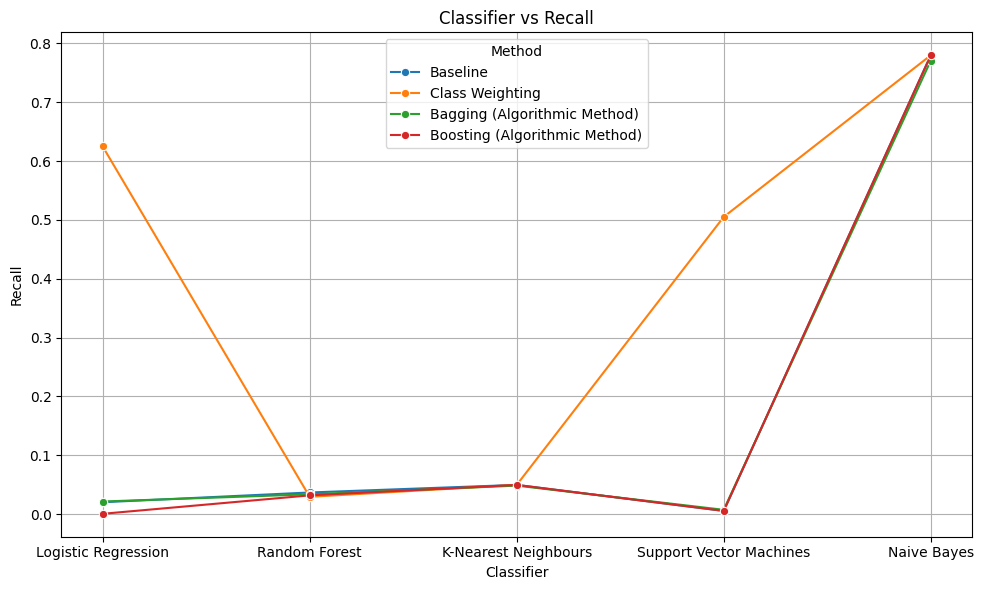

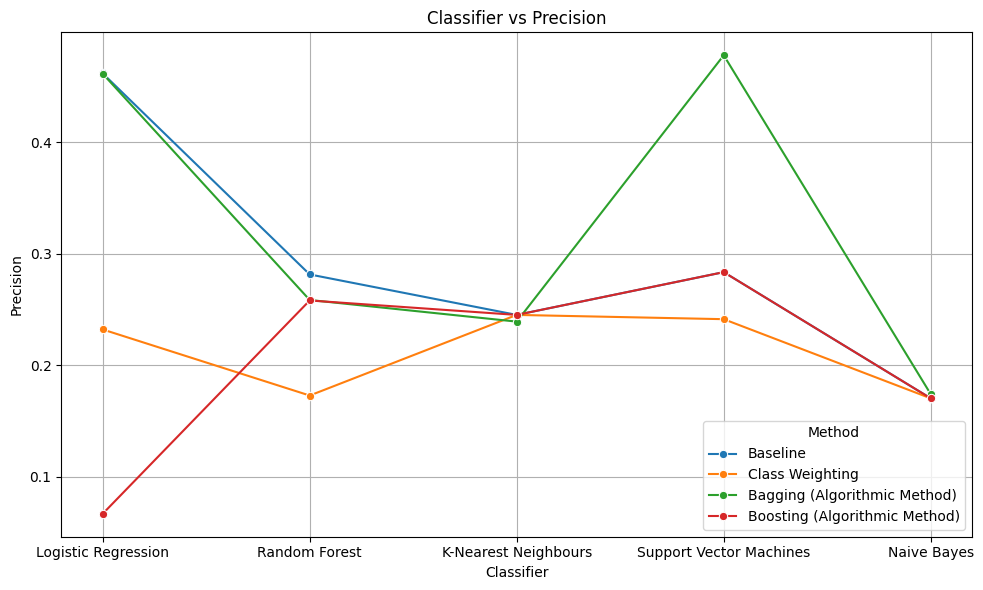

In [20]:
# Concatenate the results
results_df = pd.concat([baseline_results, class_weighting_results, bagging_results, boosting_results])
# Print results
print(results_df)
results_df.to_csv('Results/BiddingData.AlgorithmicMethodsResults.csv', index=False)
# Plot a Classifier vs Recall Graph -> To evaluate how well the model is performing to detect the fraudulent transactions (minority class)
plot_model_recall_graph(results_df)
# Plot a Classifier vs Precision Graph -> To evaluate how precise the model is to detect the minority class (can be used as a secondary metric for evaluation)
plot_model_precision_graph(results_df)